In [1]:
%matplotlib inline
import numpy as np
from numpy import random
from matplotlib import pyplot as plt
import seaborn as sns

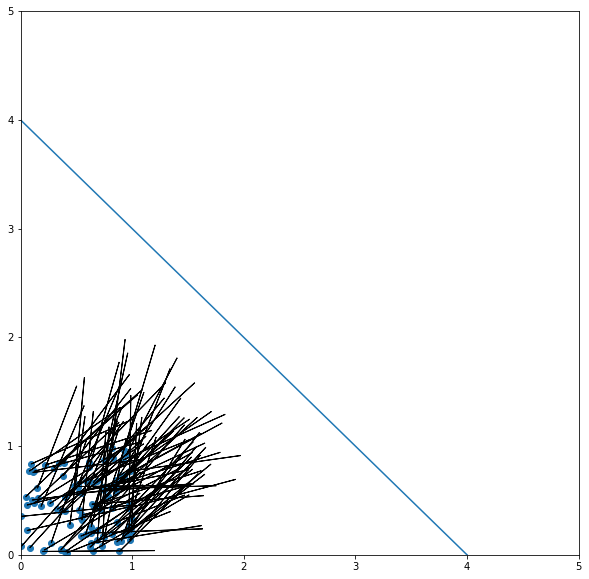

In [2]:
pareto_slope = -1.0
pareto_intercept = 4
xs = np.arange(-1, 5, 0.01)
ys = pareto_slope*xs + pareto_intercept
npts = 100
pts = random.rand(npts,2)

# Random unit vectors
selection_vectors = random.rand(npts*2).reshape(npts,2)
norms = np.expand_dims(np.linalg.norm(selection_vectors, axis=1), axis=1)
selection_vectors /= norms

figure = plt.figure(figsize=(10,10))
plt.plot(xs, ys)

plt.scatter(pts[:,0], pts[:,1])
for i in range(pts.shape[0]):
    plt.arrow(pts[i,0], pts[i,1], selection_vectors[i,0], selection_vectors[i,1])

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.show()

In [3]:
%%time 

# Model selection + drift as a velocity term plus a diffusion term.
k_diffusion = 1
k_velocity = 10
ks = np.array([k_diffusion, k_velocity])
nts = int(100000)
dts = []

def _slope(p1, p2):
    return p2[1] - p1[1] / (p2[0] - p1[0])

def _yintercept(p1, slope):
    return p1[1] - slope * p1[0]

def pareto_intersect(p1, p2):
    m = _slope(p1, p2)
    b = _yintercept(p1, m)
    
    # Check for parallel lines
    assert np.abs(m - pareto_slope) > 1e-5
    
    x_int = b - pareto_intercept / (pareto_slope - m)
    y_int = pareto_slope*x_int + pareto_intercept
    return np.array([x_int, y_int])


for ts in range(nts):
    k_tot = np.sum(ks)*npts
    dt = random.exponential(1.0/k_tot)
    dts.append(dt)
    probs = ks * npts / k_tot
    
    dude_idx = random.randint(0, npts)
    if random.rand() < probs[0]:
        # Diffusion/drift
        motion = dt * random.normal(size=(1,2))[0]
    else:
        # Selection
        motion = dt * selection_vectors[dude_idx, :]
    
    # Check if the position crosses the pareto surface
    pos = pts[dude_idx, :]
    new_pos = pos + motion
    
    pareto_y = pareto_slope*new_pos[0] + pareto_intercept
    pareto_x = (new_pos[1] - pareto_intercept)/pareto_slope
    if new_pos[0] > pareto_x or new_pos[1] > pareto_y:
        # Project back to line along dimension of motion. 
        new_pos = pareto_intersect(pos, new_pos)
        
    
    # Update position
    pts[dude_idx, :] = new_pos

CPU times: user 2.14 s, sys: 15.8 ms, total: 2.15 s
Wall time: 2.19 s


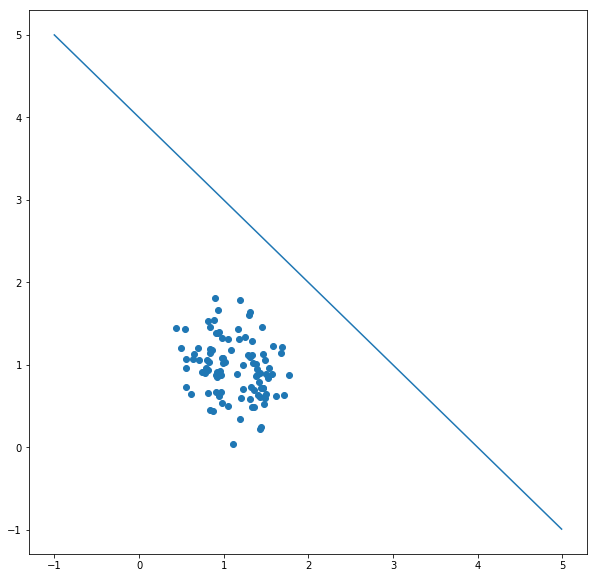

In [4]:
figure = plt.figure(figsize=(10,10))
plt.plot(xs, ys)

plt.scatter(pts[:,0], pts[:,1])
plt.show()